To run nebula scirbt you need the follwing libraries:

```R
    library(glue)
    library(dplyr)
    library(getopt)
    library(Matrix)
    library(qs)
    library(Seurat)
    library(nebula)
    library(future)
```

```R
install.packages("getopt")

if (!require("devtools")) install.packages("devtools")
devtools::install_github("lhe17/nebula")

```

R scritp from [link](https://github.com/bdferris642/sc-online/tree/main/scripts)

In [43]:
# ATTENTION: need for perpty of running jupternotbook
%matplotlib inline

%load_ext autoreload
%autoreload 2



import pandas as pd
import numpy as np
from scipy import sparse
import scanpy as sc
import matplotlib.pyplot as plt
import os

from dotenv import load_dotenv; load_dotenv()


from utils import preprocessing
from utils import DEG


GRADIENT_GENES_CORR_PATH = os.getenv("GRADIENT_GENES_CORR_PATH")
PARALLEL_NEBULA_SCRIPT_PATH = os.getenv("PARALLEL_NEBULA_SCRIPT")

# name of cell tyoe vauble annotaton to use in this analsys
CT_FOR_DEG_VARIABLE = "Group_name" #"Group_name"
# name of Sample varibale
SAMPLE_VARIABLE = "donor_id"
# variable to test if differtially epxressed
CONTRAST_VARIABLE = "case_control"
# Level of contrat varibale to use as baseline
CONTRAST_BASELINE = "control"
# Level of contrat varibale to use as stimulated
CONTRAST_STIM = "case"
# Varibale combainstion to make groups (SAMPLE_VARIABLE non necessary)
COV_FOR_PSEUDOBULK = [CT_FOR_DEG_VARIABLE]
# Obs col names that groups psudocells in groups in which perfomr DEG in them --> it is made using the var in COV_FOR_PSEUDOBULK
GROUP_DEG_COL = "pseudobulk_group_for_DEG"

# tmp folder where to save intemrediate results
QS_TMP_FOLDER = "/home/gdallagl/myworkdir/XDP/data/_old/nebula_tmp"

# Covariates to use for stat test
COVARIATES_FOR_DEG = ["Age.at.Death", "Sex", "PMI", "pct_mt", "pct_intronic"]
# libraru size col for  enbula
LIBRARY_SIZE_COL = "nCount_RNA"
# Interesting cov (covarintes that are not used for the analys but still want to rpesevr in pesudobulk obs)
INTERESTING_COV = ["nCount_RNA", "nFeature_RNA", "pct_ribosomal", "library", "Cause.of.Death"]

# mitluple etst correction pvalue thr
ALPHA_MULTIPLE_TEST = 0.05
LOGFC_THR=0.1
PVAL_THR=0.05

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read adata

In [2]:
adata = sc.read_h5ad(
    #"/home/gdallagl/myworkdir/XDP/data/XDP/NucSec/original_data/NucSeq_all_labelled_zoned.h5ad", 
    "/home/gdallagl/myworkdir/XDP/data/XDP/artificial_bican/geneset_001/zonated_objs_combined_with_md__combined__rep_001__ventral_matrix_keep_1.0_raw.h5ad",
    #backed="r"
    )

#adata = adata[adata.obs.spn_type == "dorsal_matrix"].copy()


adata

AnnData object with n_obs × n_vars = 191639 × 37905
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor_id', 'PREFIX', 'CELL_BARCODE', 'NUM_GENIC_READS', 'NUM_TRANSCRIPTS', 'NUM_GENES', 'num_retained_transcripts', 'pct_coding', 'pct_utr', 'pct_intergenic', 'pct_genic', 'pct_intronic', 'pct_mt', 'pct_ribosomal', 'frac_contamination', 'experiment', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'x', 'y', 'library', 'donor', 'x_um2', 'y_um2', 'unique_cell_ID', 'cb', 'Final_Zone_Assignments', 'Group_name.1', 'cell_type', 'Cohort', 'Biobank', 'Age.at.Death', 'Sex', 'Race', 'Ethnicity', 'Cause.of.Death', 'PMI', 'spn_type', 'case_control', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.5', 'Row.names', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'P

In [ ]:
# adata_c = sc.read_h5ad("/home/gdallagl/myworkdir/XDP/data/XDP/diseased/sample_01/adata/all_lib_adata_zoned.h5ad")
# adata_c.var_names = adata_c.var.gene_symbol.astype(str)
# adata_c.var_names_make_unique() 

# Calculate gradient-score

Specific for cell type (all samples together).

In [4]:
def compute_gradient_score(adata, gradient_csv_path, 
                          p_threshold=0.05,
                          corr_threshold=None, 
                          use_layer=None,
                          standardize=True):
    """
    Compute dorsal-ventral gradient scores.
    
    Parameters:
    -----------
    adata : AnnData
        Single-cell data
    gradient_csv_path : str
        Path to gradient gene CSV
    p_threshold : float
        P-value threshold (default: 0.05)
    corr_threshold : float, optional
        Minimum absolute correlation (e.g., 0.1)
    use_layer : str or None
        'raw', 'counts', or None for adata.X
    standardize : bool
        Z-score normalize genes (recommended: True)
    
    Returns:
    --------
    dict with gradient_score, dorsal_score, ventral_score
    """
    # Load and filter gradient data
    gradient_df = pd.read_csv(gradient_csv_path)
    gradient_df = gradient_df[gradient_df['combined_p'] < p_threshold]
    
    if corr_threshold:
        gradient_df = gradient_df[np.abs(gradient_df['mean_spearman']) >= corr_threshold]
    
    gradient_df = gradient_df[gradient_df['gene'].isin(adata.var_names)]
    
    # Split dorsal/ventral
    dorsal_df = gradient_df[gradient_df['mean_spearman'] > 0]
    ventral_df = gradient_df[gradient_df['mean_spearman'] < 0]
    
    print(f"Using {len(gradient_df)} genes (p<{p_threshold}): "
          f"{len(dorsal_df)} dorsal, {len(ventral_df)} ventral")
    
    # Get expression matrix
    if use_layer == 'raw':
        X = adata.raw.X if adata.raw else adata.X
        var_names = adata.raw.var_names if adata.raw else adata.var_names
    elif use_layer:
        X = adata.layers[use_layer]
        var_names = adata.var_names
    else:
        X = adata.X
        var_names = adata.var_names
    
    # Helper function to compute score
    def compute_score(df, negate=False):
        if len(df) == 0:
            return np.zeros(X.shape[0])
        
        idx = [list(var_names).index(g) for g in df['gene']]
        X_sub = X[:, idx]
        
        if sparse.issparse(X_sub):
            X_sub = X_sub.toarray()
        
        if standardize:
            means = X_sub.mean(axis=0)
            stds = X_sub.std(axis=0)
            stds[stds == 0] = 1
            X_sub = (X_sub - means) / stds
        
        weights = df['mean_spearman'].values
        score = X_sub @ weights
        
        return -score if negate else score
    
    # Compute scores
    gradient_scores = compute_score(gradient_df)
    dorsal_scores = compute_score(dorsal_df)
    ventral_scores = compute_score(ventral_df, negate=True)
    
    # Store in adata
    adata.obs['gradient_score'] = gradient_scores
    adata.obs['dorsalness'] = gradient_scores
    adata.obs['dorsal_score'] = dorsal_scores
    adata.obs['ventral_score'] = ventral_scores
    
    return {
        'gradient_score': gradient_scores,
        'dorsal_score': dorsal_scores,
        'ventral_score': ventral_scores
    }


In [28]:
def save_files_for_R_conversion(adata, PATH_BASE):
    from scipy.io import mmwrite
    import pandas as pd
    import os
    
    os.makedirs(PATH_BASE, exist_ok=True)
    
    # Save sparse matrix (genes × cells)
    matrix_path = f"{PATH_BASE}/counts_matrix.mtx"
    mmwrite(matrix_path, adata.X.T)
    
    # Save gene names
    genes_path = f"{PATH_BASE}/genes.txt"
    with open(genes_path, 'w') as f:
        for gene in adata.var_names:
            f.write(f"{gene}\n")
    
    # Save cell/sample names
    barcodes_path = f"{PATH_BASE}/barcodes.txt"
    with open(barcodes_path, 'w') as f:
        for barcode in adata.obs_names:
            f.write(f"{barcode}\n")
    
    # Save metadata
    metadata_path = f"{PATH_BASE}/metadata.csv"
    adata.obs.to_csv(metadata_path)

def build_qs_from_python_files(PATH_BASE, output_qs_name="R_obj"):
    import rpy2.robjects as ro
    r = ro.r
    
    r(f'''
    library(Matrix)
    library(Seurat)
    library(qs)
    
    # Read sparse matrix
    mtx <- readMM("{PATH_BASE}/counts_matrix.mtx")
    
    # Read gene and sample names
    genes <- readLines("{PATH_BASE}/genes.txt")
    barcodes <- readLines("{PATH_BASE}/barcodes.txt")
    
    # Assign names
    rownames(mtx) <- genes
    colnames(mtx) <- barcodes
    
    # Read metadata
    metadata <- read.csv("{PATH_BASE}/metadata.csv", row.names=1)
    
    # Create Seurat object
    sobj <- CreateSeuratObject(counts = mtx, meta.data = metadata)
    
    # Save as .qs
    qsave(sobj, "{PATH_BASE}/{output_qs_name}.qs")
    ''')
    

In [31]:
a

AnnData object with n_obs × n_vars = 26522 × 37905
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor_id', 'PREFIX', 'CELL_BARCODE', 'NUM_GENIC_READS', 'NUM_TRANSCRIPTS', 'NUM_GENES', 'num_retained_transcripts', 'pct_coding', 'pct_utr', 'pct_intergenic', 'pct_genic', 'pct_intronic', 'pct_mt', 'pct_ribosomal', 'frac_contamination', 'experiment', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'x', 'y', 'library', 'donor', 'x_um2', 'y_um2', 'unique_cell_ID', 'cb', 'Final_Zone_Assignments', 'Group_name.1', 'cell_type', 'Cohort', 'Biobank', 'Age.at.Death', 'Sex', 'Race', 'Ethnicity', 'Cause.of.Death', 'PMI', 'spn_type', 'case_control', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.5', 'Row.names', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC

In [32]:
# Initialize X_umap if it doesn't exist
if 'X_umap' not in adata.obsm:
    adata.obsm['X_umap'] = np.full((adata.shape[0], 2), np.nan)

for ct in adata.obs[CT_FOR_DEG_VARIABLE].unique():

    a = adata[adata.obs[CT_FOR_DEG_VARIABLE] == ct].copy()

    print(ct, a)

    #############################
    # Save counts

    if "counts" in a.layers:
        print("Putting raw counts in .X")
        a.X = a.layers["counts"].copy()
    else:
        a.layers["counts"] = a.X.copy()
        print("Be sure that .X is raw counts")

    #############################
    # Compute gradients
    scores = compute_gradient_score(
        a,
        GRADIENT_GENES_CORR_PATH,
        use_layer="counts",
        standardize=True,
        p_threshold=0.05,
        corr_threshold=0.1
    )

    # SAVE BACK to original adata (only for these cells)
    adata.obs.loc[a.obs_names, 'gradient_score'] = a.obs['gradient_score']
    adata.obs.loc[a.obs_names, 'dorsal_score'] = a.obs['dorsal_score']
    adata.obs.loc[a.obs_names, 'ventral_score'] = a.obs['ventral_score']

    #############################
    # Save qs

    save_files_for_R_conversion(a, QS_TMP_FOLDER)
    build_qs_from_python_files(QS_TMP_FOLDER)

    break

    #############################À
    # Compute umap

    preprocessing.preprocess(a, save_raw_counts=(not("counts" in a.layers)))
    #a.obs["Final_Zone_Assignments"] = a.obs["Final_Zone_Assignments"].astype("category")

    # remoc .X useless
    import scipy.sparse as sp
    a.X = sp.csr_matrix(a.shape)

    # SAVE BACK to original adata (only for these cells)
    cell_indices = [adata.obs_names.get_loc(cell) for cell in a.obs_names]
    adata.obsm['X_umap'][cell_indices, :] = a.obsm['X_umap']

    #############################À
    # Plot umap

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sc.pl.embedding(a, basis="X_umap", color='gradient_score', cmap='RdBu_r', 
                    ax=axes[0], show=False, title='Combined')
    sc.pl.embedding(a, basis="X_umap", color='dorsal_score', cmap='Reds',
                    ax=axes[1], show=False, title='Dorsal')
    sc.pl.embedding(a, basis="X_umap", color='ventral_score', cmap='Blues',
                    ax=axes[2], show=False, title='Ventral')
    plt.tight_layout()
    plt.show()

    # Histograms
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for ax, col, color, title in zip(axes, 
                                    ['gradient_score', 'dorsal_score', 'ventral_score'],
                                    ['purple', 'red', 'blue'],
                                    ['Combined', 'Dorsal', 'Ventral']):
        ax.hist(a.obs[col], bins=100, color=color, alpha=0.7)
        ax.set_xlabel(f'{title} Score')
        ax.axvline(0, color='black', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # only if it has spatial:
    if "spatial" in adata.obsm:
        sc.pl.embedding(a, basis="spatial", color=["gradient_score", "ventral_score", "dorsal_score"])

    break

STRv_D1_MSN AnnData object with n_obs × n_vars = 26522 × 37905
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'donor_id', 'PREFIX', 'CELL_BARCODE', 'NUM_GENIC_READS', 'NUM_TRANSCRIPTS', 'NUM_GENES', 'num_retained_transcripts', 'pct_coding', 'pct_utr', 'pct_intergenic', 'pct_genic', 'pct_intronic', 'pct_mt', 'pct_ribosomal', 'frac_contamination', 'experiment', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Class_name', 'Class_bootstrapping_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Group_name', 'Group_bootstrapping_probability', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'x', 'y', 'library', 'donor', 'x_um2', 'y_um2', 'unique_cell_ID', 'cb', 'Final_Zone_Assignments', 'Group_name.1', 'cell_type', 'Cohort', 'Biobank', 'Age.at.Death', 'Sex', 'Race', 'Ethnicity', 'Cause.of.Death', 'PMI', 'spn_type', 'case_control', 'RNA_snn_res.0.2', 'seurat_clusters', 'RNA_snn_res.0.5', 'Row.names', 'PC_1', 'PC_2', 'PC_3', 'PC_4',

2026-01-26 18:41:23 | [WARNING] R callback write-console: Loading required package: SeuratObject
  
2026-01-26 18:41:24 | [WARNING] R callback write-console: Loading required package: sp
  
2026-01-26 18:41:25 | [WARNING] R callback write-console: 
Attaching package: ‘SeuratObject’

  
2026-01-26 18:41:25 | [WARNING] R callback write-console: The following objects are masked from ‘package:base’:

    %||%, intersect, t

  



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

2026-01-26 18:41:27 | [WARNING] R callback write-console: 
Attaching package: ‘Seurat’

  
2026-01-26 18:41:27 | [WARNING] R callback write-console: The following object is masked from ‘package:base’:

    %||%

  
2026-01-26 18:41:27 | [WARNING] R callback write-console: qs 0.27.3. Announcement: https://github.com/qsbase/qs/issues/103
  
2026-01-26 18:43:18 | [WARNING] R callback write-console: Warning:  
2026-01-26 18:43:18 | [WARNING] R callback write-console:  Data is of class dgTMatrix. Coercing to dgCMatrix.
  


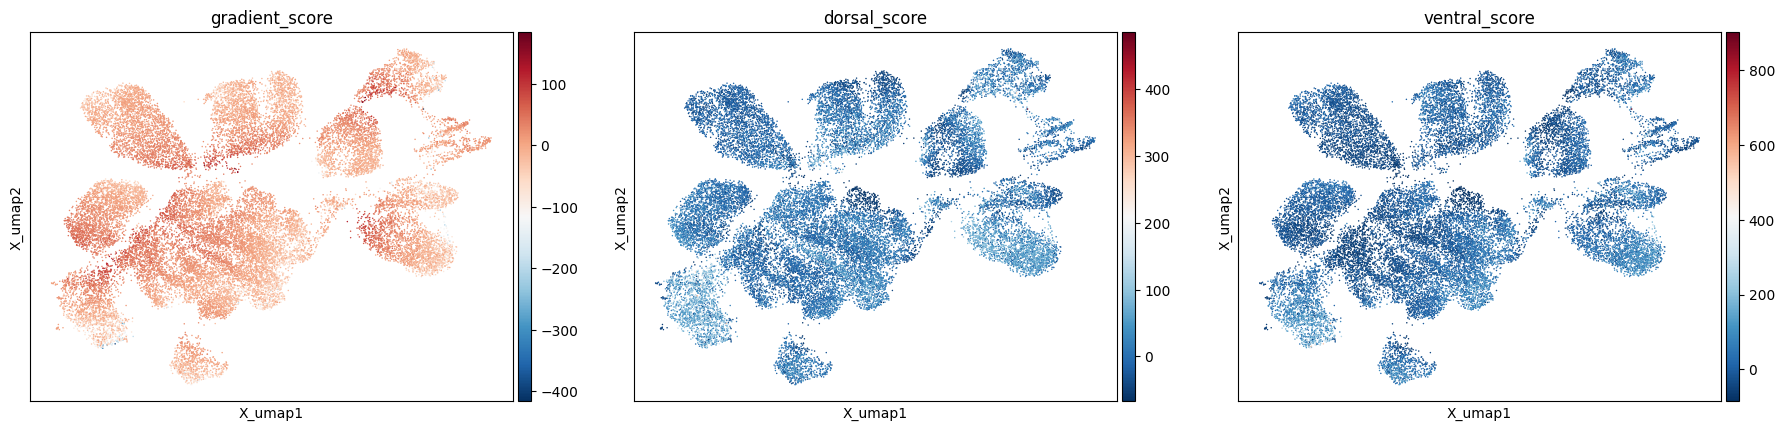

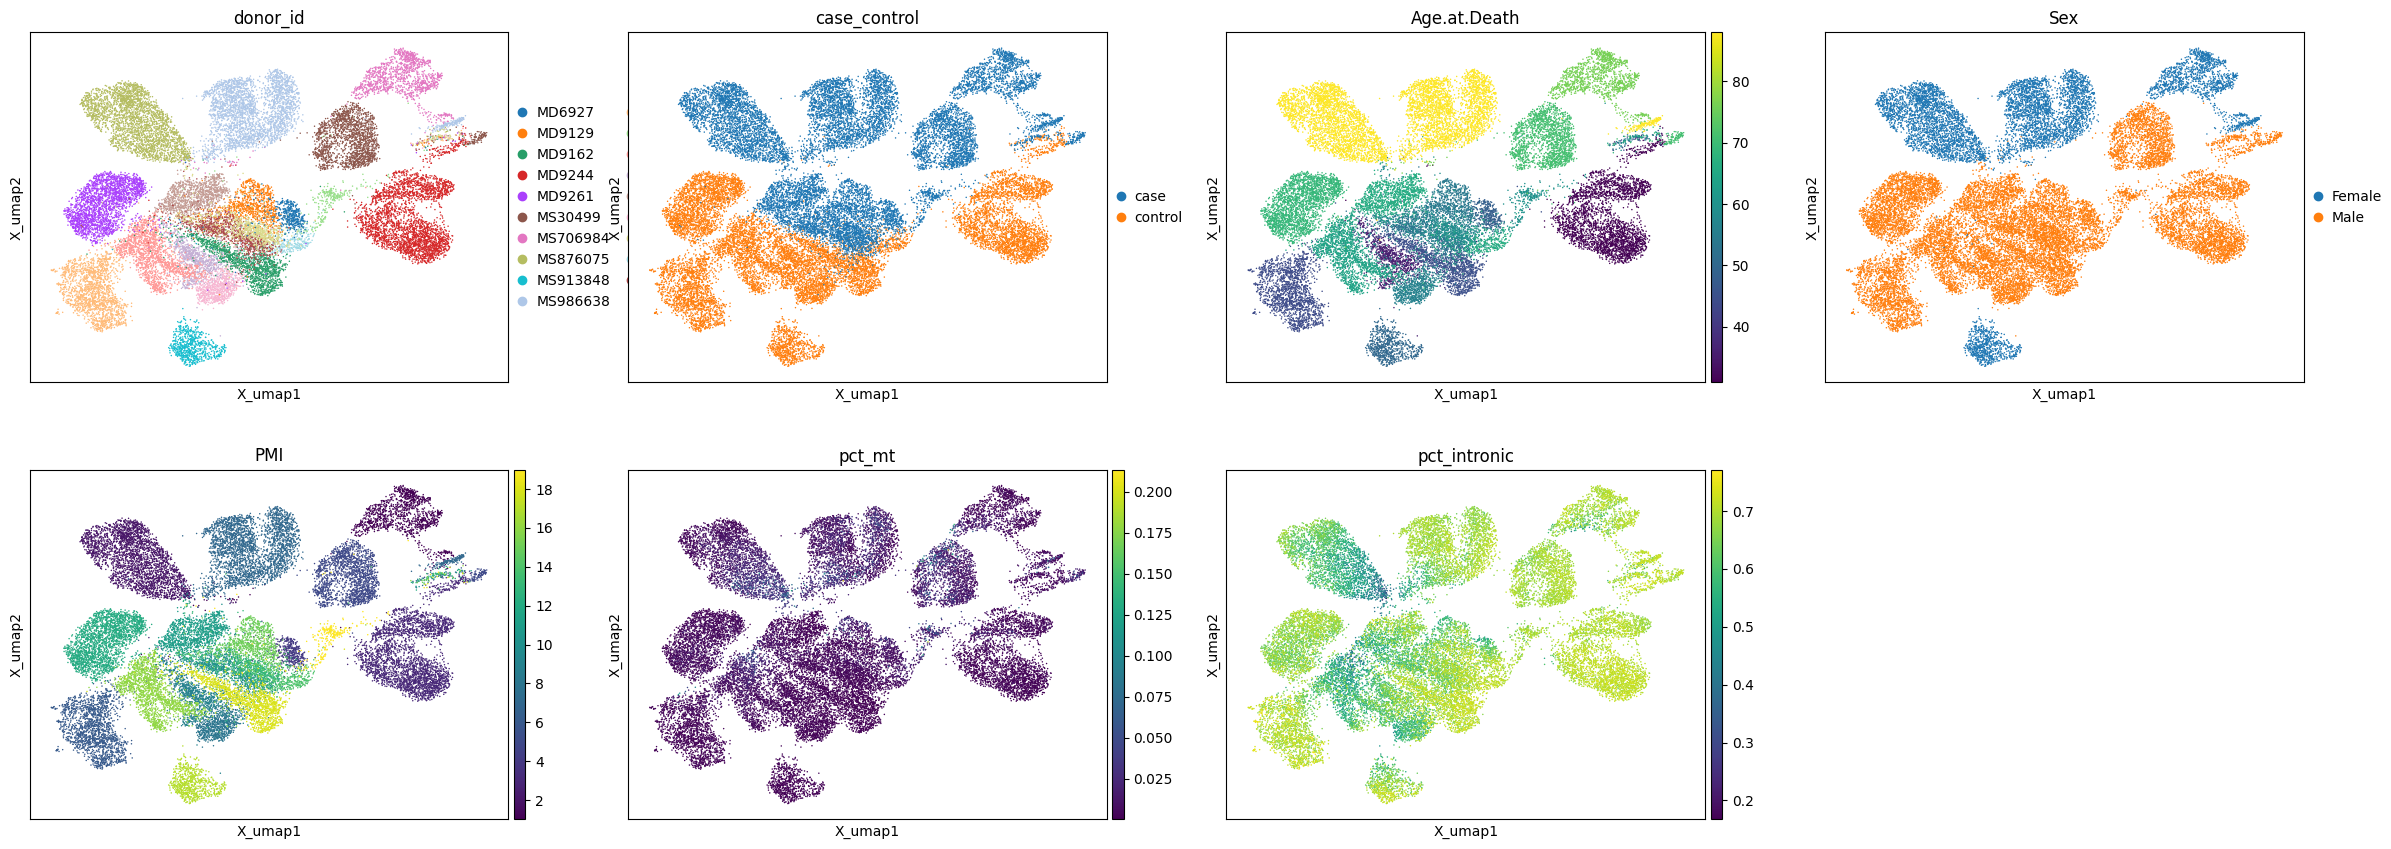

In [24]:
sc.pl.embedding(a, basis="X_umap", color=['gradient_score', 'dorsal_score', 'ventral_score'] , cmap='RdBu_r')# vmin=-100, vmax=100)
sc.pl.embedding(a, basis="X_umap", color=[SAMPLE_VARIABLE, CONTRAST_VARIABLE, *COVARIATES_FOR_DEG, ])# vmin=-100, vmax=100)

# DEG

In [3]:
FULL_MODEL = "~ " + " + ".join([CONTRAST_VARIABLE, *COVARIATES_FOR_DEG, "gradient_score"])
print(FULL_MODEL)


~ case_control + Age.at.Death + Sex + PMI + pct_mt + pct_intronic + gradient_score


In [48]:
for ct in adata.obs[CT_FOR_DEG_VARIABLE].unique():

    a = adata[adata.obs[CT_FOR_DEG_VARIABLE] == ct].copy()

    # Save tmp .qs

    # Run Nebula
    nebula_result_path = DEG.run_nebula_parallel_script(
        path_qs = f"{QS_TMP_FOLDER}/R_obj.qs",
        path_nebula_script = PARALLEL_NEBULA_SCRIPT_PATH,
        id_col = SAMPLE_VARIABLE,
        covs = [CONTRAST_VARIABLE, *COVARIATES_FOR_DEG], # wihtout LIBRARY_SIZE_COL, with constrst vaibale too
        offset_col = LIBRARY_SIZE_COL,
        n_folds = 8,
        n_cores = 16,
        save_tmp = False,
        suffix = None,
    )

    break
    

Running command: bash /home/gdallagl/myworkdir/XDP/utils/nebula_scripts/run-nebula-parallel.sh --path /home/gdallagl/myworkdir/XDP/data/_old/nebula_tmp/R_obj.qs --id-col donor_id --offset-col nCount_RNA --n-folds 8 --n-cores 16 --save-tmp 0 --covs case_control,Age.at.Death,Sex,PMI,pct_mt,pct_intronic
❌ ERROR running NEBULA script!

Command: bash /home/gdallagl/myworkdir/XDP/utils/nebula_scripts/run-nebula-parallel.sh --path /home/gdallagl/myworkdir/XDP/data/_old/nebula_tmp/R_obj.qs --id-col donor_id --offset-col nCount_RNA --n-folds 8 --n-cores 16 --save-tmp 0 --covs case_control,Age.at.Death,Sex,PMI,pct_mt,pct_intronic

STDOUT:
[INFO] Input: /home/gdallagl/myworkdir/XDP/data/_old/nebula_tmp/R_obj.qs
[INFO] Script dir: /home/gdallagl/myworkdir/XDP/utils/nebula_scripts
[INFO] Base name: R_obj.qs
[INFO] Geneset dir: /home/gdallagl/myworkdir/data/_old/nebula_tmp
[INFO] Geneset: nebula_tmp
[INFO] Split dir: /home/gdallagl/myworkdir/data/_old
[INFO] Split: _old
[INFO] n-folds: 8
[INFO] para

CalledProcessError: Command '['bash', '/home/gdallagl/myworkdir/XDP/utils/nebula_scripts/run-nebula-parallel.sh', '--path', '/home/gdallagl/myworkdir/XDP/data/_old/nebula_tmp/R_obj.qs', '--id-col', 'donor_id', '--offset-col', 'nCount_RNA', '--n-folds', '8', '--n-cores', '16', '--save-tmp', '0', '--covs', 'case_control,Age.at.Death,Sex,PMI,pct_mt,pct_intronic']' returned non-zero exit status 8.